In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [2]:
#Cargo ambos dataframes train y test y los almaceno en una lista
X_train = pd.read_csv(r"C:\Users\user\Desktop\daniel\DATA SCIENCE\HENRY\HENRY BOOTCAMP\HACKATON\Hackathon\Housing Dreams\house_train_raw.csv")
X_test = pd.read_csv(r"C:\Users\user\Desktop\daniel\DATA SCIENCE\HENRY\HENRY BOOTCAMP\HACKATON\Hackathon\Housing Dreams\houses_test_raw.csv")
df_list = [X_train,X_test]

In [3]:
#Concateno los df's para una correcta codificación
df = pd.concat(df_list)
#Establezco el indice para todo el df con la columna Id:
df.set_index(df["Id"],inplace=True)
df.drop(columns=["Id"],inplace=True)
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN


In [4]:
#Verificamos la cantidad de valores nulos:
df.isnull().sum()[df.isnull().sum() > 0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64

## Imputacion de las variables que mas valores nulos poseen

In [5]:
#Creo una lista con las columnas que mas valores nulos tienen para una facil consulta
cols_with_high_nan = [col for col in df.columns if df[col].isnull().sum() > 500]
cols_with_high_nan

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'SalePrice']

In [6]:
#Revisando el diccionario de datos para estas columnas con un alto numero de NA's podemos ver que hay valores nulos porque no se tiene esa caracteristica en esa casa, ya sea, callejon, valla, chimenea o Piscina, asi que imputamos esos valores por NONE
#Tenemos cuidado de no imputar valores en la variable target SalePrice, ya que ella nos servira mas adelante para separar nuevamente nuestros df's en train y test
cols_with_high_nan.remove("SalePrice")
for col in cols_with_high_nan:
    df.loc[df[col].isnull(), col] = "None"

Investigando LotFrontage, no se tiene una razon especifica por la cual falten valores en este campo, asi que idearemos un metodo para imputar sus valores faltantes

<AxesSubplot:xlabel='LotFrontage'>

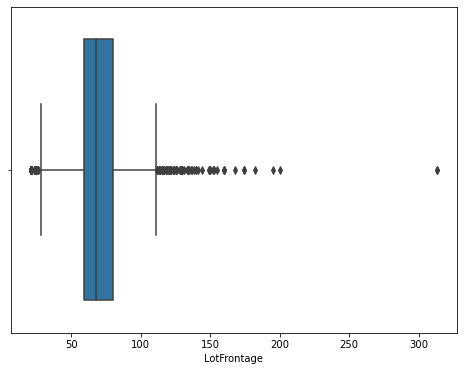

In [7]:
#Verificamos los outliers de LotFrontage:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=df,x="LotFrontage",ax=ax)

In [8]:
#LotFrontage tiene outliers por lo tanto me deshare de ellos para mi imputacion de valores nulos
q3, q1 = np.nanpercentile(np.array(X_train.LotFrontage.values), [75,25])
iqr = q3-q1
h_outliers, l_outliers = (q3 + 1.5*iqr), (q1 - 1.5*iqr)


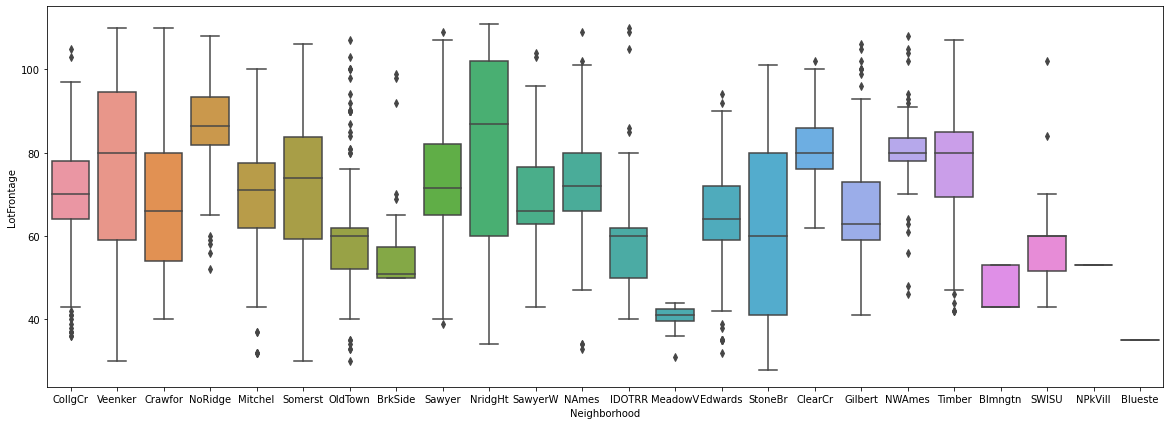

In [9]:
#Creo una grafica que me muestra la distribucion aproximada de LotFrontage sin outliers por Neighborhood
fig, ax = plt.subplots(figsize=(20,7))
sns.boxplot(data = df[(df.LotFrontage < h_outliers) & (df.LotFrontage > l_outliers) ],x="Neighborhood",y="LotFrontage",ax=ax)
plt.show()

In [10]:
#Aqui agrupo por neighborhood para sacar la media de LotFrontage
median_lotfront_per_neighbour = pd.DataFrame(df[(df.LotFrontage < h_outliers) & (df.LotFrontage > l_outliers) ].groupby("Neighborhood")["LotFrontage"].median())
#Ahora creo un diccionario que me servira para imputar los valores nulos de LotFrontage. Se reemplazaran con la mediana de cada vecindario
map_dict = {median_lotfront_per_neighbour.LotFrontage.index[i] : median_lotfront_per_neighbour.LotFrontage.values[i] for i in range(len(median_lotfront_per_neighbour.LotFrontage.index))}
#Imputo los valores nulos:
df.loc[df.LotFrontage.isnull(),"LotFrontage"] = df[df.LotFrontage.isnull()].Neighborhood.map(map_dict)

## Imputacion de las demas variables

In [11]:
#Verifico cuales columnas poseen nulos y cuantos valores son
df.isna().sum()[df.isna().sum()>0]

MSZoning           4
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
SaleType           1
SalePrice       1459
dtype: int64

In [12]:
#Hay algunos valores nulos en las columnas relacionadas con el garage y basement que se deben imputar. Revisando el diccionario, verificamos que se debe a que estas casas no tienen un garage, o un Basement asi que imputamos los valores nulos por NONE,#Para el campo MasVnrType verificamos que los campos con NA es porque no tienen chapa de mamposteria
for col in ["GarageType","GarageFinish","GarageQual","GarageCond","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","MasVnrType"]:
    df.loc[df[col].isnull(),col] = "None"

#Ahora, las columnas que dependen del garage y del basement son las siguientes:
#Se setean en cero ya que, no se tiene garage o basement y por lo tanto estas variables deben estar en cero
for col in ["GarageYrBlt","GarageArea","GarageCars",'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',"MasVnrArea"]:
    df.loc[df[col].isnull(),col] = 0

In [13]:
#Dropeamos la columna Utilities ya que no nos sirve para nuestro modelo, porque tenemos solo 1 valor en NoSeWa y es en el set de train 
df.drop(columns=["Utilities"],inplace=True)
#Creamos una lista con las columnas restantes que contienen NA's, para reeemplazarlas por los valores mas frecuentes
cols_na_left = df.isna().sum()[df.isna().sum()>0].index.tolist()
#Seguimos teniendo cuidado de no incluir SalePrice en la lista para que no sea imputada
cols_na_left.remove("SalePrice")

In [14]:
#Instanciamos un SimpleImputer para reeemplar los NA por los valores mas frecuentes de esa columna.
se = SimpleImputer(strategy="most_frequent")
df[cols_na_left] = se.fit_transform(df[cols_na_left])
df.isna().sum()[df.isna().sum()>0]

SalePrice    1459
dtype: int64

### Ahora, cambiamos el tipo de columnas de algunas variables


In [15]:
#Cambiamos MSSubClass en una variable categorica ya que se refiere al tipo de vivienda
df['MSSubClass'] = df['MSSubClass'].apply(str)
#Cambiamos overallcond en una variable categorica ordinal
df['OverallCond'] = df['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

## Codificacion de Variables categoricas 

In [16]:
#Hice una exploracion de cada campo, verificando si es una variable ordinal o nominal, ya que hay diferencia entre este tipo de variables categoricas
#cada una se codifica de una manera distinta. Las variables que pueden ser ordenadas las almacene en "ordinal_cols"
from sklearn.preprocessing import LabelEncoder
ordinal_cols = ["Street", "LotShape", "LandContour", "LandSlope", "MSSubClass", "OverallQual","OverallCond","ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","HeatingQC","CentralAir","Electrical","KitchenQual","FireplaceQu","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","YrSold","MoSold"]

#Ahora se transforman:
for col in ordinal_cols:
    le = LabelEncoder()
    le.fit(list(df[col].values)) 
    df[col] = le.transform(list(df[col].values))

In [17]:
#Variables categoricas nominales:
categorical_variables = [col for col in df.columns if df[col].dtype == "object"]
len(categorical_variables)

21

In [18]:
#Removemos nuestra variable target del dataframe para que no interfiera con el onehotencoder
y_train = df.pop("SalePrice")

In [19]:
#Importamos lo necesario para realizar el One Hot encoder:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown="ignore",sparse=False), categorical_variables)],#Los nuevos valores que se encuentren en las columnas de test, los ignorará (AUNQUE no hay valores nuevos porque esta usando todo el dataframe combinado)
                         remainder='passthrough') #transformamos las columnas categoricas, y las demas cols las pasamos de largo
                         
df_encoded = pd.DataFrame(ct.fit_transform(df), columns=ct.get_feature_names_out())
df_encoded.index = df.index 

In [20]:
print(df.shape,df_encoded.shape)

(2919, 78) (2919, 223)


In [21]:
#Inserto mi variable "y" solamente para separar el dataframe en test y en train 
df_encoded.insert(0,"y",y_train)

In [22]:
#Separo los dataframes con ayuda de la variable "y" que inserté
#La parte del df donde "y" es nula es el conjunto de TEST y donde no es nula, es el conjunto de TRAINING
X_train = df_encoded[~df_encoded.y.isnull()]
X_test = df_encoded[df_encoded.y.isnull()]
#Establezo mi variable target con su longitud correcta:
y_train = X_train["y"]
#Dropeo de ambos df's la variable para no cometer ningun error de prediccion
X_train.drop(columns=["y"],inplace=True)
X_test.drop(columns=["y"],inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_15072\997264388.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns=["y"],inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_15072\997264388.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns=["y"],inplace=True)


## Creacion del modelo y obtencion del error

In [23]:
train_x, test_x, train_y, test_y = train_test_split(X_train,y_train, test_size = 0.3)

In [24]:
#Instanciamos el modelo, y seteamos los parametros apropiados, despues de haber tratado con varias combinaciones:
xgb = XGBRegressor( n_estimators=1500, learning_rate=0.06 )
xgb.fit(train_x,train_y)
#Predecimos sobre la data de test para ver la metrica:
pred_y = xgb.predict(test_x)
print(mean_squared_log_error(test_y, pred_y,squared=False))

0.1311201369951283


In [25]:
#Ahora predecimos sobre el conjunto de testing (El que realmente nos importa)
test_predictions = xgb.predict(X_test)
#Genero un dataset de mis predicciones y agrego el indice, para identificar cada registro, ya que se dropearon algunos valores (muy pocos)
test_predictions = pd.DataFrame(test_predictions,columns=["preds"])
#Guardo mis predicciones en un csv
test_predictions.to_csv(r"C:\Users\user\Desktop\daniel\DATA SCIENCE\HENRY\HENRY BOOTCAMP\HACKATON\Hackathon\Housing Dreams\pred_test.csv",index=False)
